# Reto 1

Tu tarea consiste en clasificar el resultado de un paciente en relación con el hospital, o agruparlos con el objetivo de encontrar patrones que proporcionen mejores analisis acerca de los datos.

## Instalar librerías
- Se instala la librería ucimlrepo para la descarga de los datos necesarios para el reto.
- Se instala la librería imbalanced-learn para el tratamiento de datos con desbalance.

In [1]:
# Librería para la descarga del dataset
!pip install ucimlrepo
!pip install imbalanced-learn

## Importar librerías

In [50]:
# Obtener de datos
from ucimlrepo import fetch_ucirepo 

# Manipulación de datos
import pandas as pd
import numpy as np

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento y modelado
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Configuración warnings
import warnings
warnings.filterwarnings('ignore')

## Carga de datos 
Se cargan los datos desde la librería fetch_ucirepo y se guarda información adicional del conjunto de datos para mejor entendimiento de las variables.

In [3]:
# Obtener los datos de la librería fetch_ucirepo
data = fetch_ucirepo(id=296) 

# Guardar la información adicional como un archivo de excel para mejor visualización
data.variables.to_excel('InformacionAdicionalDatosR1.xlsx')

Esta es la información que encontraremos en el archivo de excel generado, en donde tenemos la descripción de cada variable, el tipo de datos, si se trata de variables demográficas y cuales columnas tienen datos faltantes.

**Información Relevante:**
- Hay dos variables de tipo ID que no se usarán dentro del estudio:
    * encounter_id: trabaja como la primary key de la tabla
    * patient_nbr: hay ID repetidos, pero se tratará cada registro como si fuera un paciente independiente. Esto teniendo en cuenta que las variables ya indican un seguimiento de la historia clínica.
- Únicamente 7 variables presentan valores nulos. Posteriormente analizaremos cada una de ellas.
- La mayoría de variables son categóricas y requerirán de un tratamiento especial para considerarlas en el estudio.

In [4]:
# Ver información adicional de cada variable del conjunto de datos
data.variables

,name,role,type,demographic,description,units,missing_values
0,encounter_id,ID,,None,Unique identifier of an encounter,None,no
1,patient_nbr,ID,,None,Unique identifier of a patient,None,no
2,race,Feature,Categorical,Race,"Values: Caucasian, Asian, African American, Hi...",None,yes
3,gender,Feature,Categorical,Gender,"Values: male, female, and unknown/invalid",None,no
4,age,Feature,Categorical,Age,"Grouped in 10-year intervals: [0, 10), [10, 20...",None,no
5,weight,Feature,Categorical,None,Weight in pounds.,None,yes
6,admission_type_id,Feature,Categorical,None,Integer identifier corresponding to 9 distinct...,None,no
7,discharge_disposition_id,Feature,Categorical,None,Integer identifier corresponding to 29 distinc...,None,no
8,admission_source_id,Feature,Categorical,None,Integer identifier corresponding to 21 distinc...,None,no
9,time_in_hospital,Feature,Integer,None,Integer number of days between admission and d...,None,no


In [5]:
# Definir el conjunto de datos a utilizar y poderlo tratar como un dataframe de pandas
df = pd.concat([data.data.features , data.data.targets], axis = 1)
df

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,...,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,...,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,AfricanAmerican,Male,[70-80),NaN,1,3,7,3,MC,NaN,...,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,AfricanAmerican,Female,[80-90),NaN,1,4,5,5,MC,NaN,...,No,Steady,No,No,No,No,No,No,Yes,NO
101763,Caucasian,Male,[70-80),NaN,1,1,7,1,MC,NaN,...,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,Caucasian,Female,[80-90),NaN,2,3,7,10,MC,Surgery-General,...,No,Up,No,No,No,No,No,Ch,Yes,NO


## Análisis Exploratorio y Preprocesamiento de datos

Veamos inicialmente un resumen general de los datos.

**Información Relevante:**
- Las variables admission_type_id, discharge_disposition_id y admission_source_id deberían ser variables categóricas al tratarse de ids.
- Hay algunas variables con una cantidad significativa de datos faltantes y deberá tomarse una decisión sobre su inclusión en el modelo

En esta etapa procederemos de la siguiente manera:
1. Modificar el tipo de dato de las variables que lo requieran
2. Tratar problema de datos faltantes
3. Analizar variabilidad de cada variable
4. Transformación de variables categóricas
5. Correlación de variables
6. Estandarización de variables

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 48 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      99493 non-null   object
 1   gender                    101766 non-null  object
 2   age                       101766 non-null  object
 3   weight                    3197 non-null    object
 4   admission_type_id         101766 non-null  int64 
 5   discharge_disposition_id  101766 non-null  int64 
 6   admission_source_id       101766 non-null  int64 
 7   time_in_hospital          101766 non-null  int64 
 8   payer_code                61510 non-null   object
 9   medical_specialty         51817 non-null   object
 10  num_lab_procedures        101766 non-null  int64 
 11  num_procedures            101766 non-null  int64 
 12  num_medications           101766 non-null  int64 
 13  number_outpatient         101766 non-null  int64 
 14  numb

### Modificar tipo de dato
Se modifica el tipo de dato int64 para las variables de tipo id

In [7]:
df.admission_type_id = df.admission_type_id.astype('object')
df.discharge_disposition_id = df.discharge_disposition_id.astype('object')
df.admission_source_id = df.admission_source_id.astype('object')

### Datos nulos

**A futuro:** Validar si todos los registros del mismo paciente presentan la misma información.

#### Variable race
Según las categorías presentes en esta variable, los datos nulos serán etiquetados con 'Other'. Esto teniendo en cuenta que no tener información o tener un paciente categorizado como Other, representa la misma falta de información.

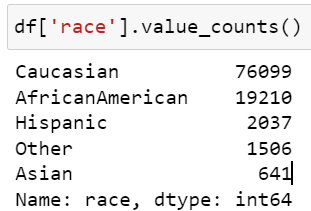

Por otro lado, como hay tan pocos registros de las clases 'Asian' e 'Hispanic', entonces vamos a etiquetarlos también como 'Other'

In [8]:
df['race'][df['race'].isna()] = 'Other'
df['race'][df['race']=='Hispanic'] = 'Other'
df['race'][df['race']=='Asian'] = 'Other'

In [9]:
df['race'].value_counts()

Caucasian          76099
AfricanAmerican    19210
Other               6457
Name: race, dtype: int64

#### Variable weight
Esta variable la eliminaremos teniendo en cuenta que más del 96% de los registros no cuentan con información y a partir del menos del 4% de los pacientes es inviable generarla.
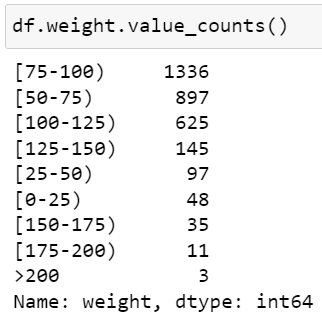

In [10]:
weight_null_per = (df.weight.isna().sum()/len(df))*100
print(f'Porcentaje de valores nulos: {weight_null_per}')

Porcentaje de valores nulos: 96.85847925633315


In [11]:
df.drop(columns='weight', inplace=True)

#### Variable payer_code
Esta variable cuenta con más del 39% de datos nulos. Mi propuesta es etiquetarlos con una clase nueva llamada "Other" y posteriormente analizar si la variable resulta relevante para el estudio o no.

**Observación - DUDA:** Si hago esto, la etiqueta mayoritaria sería Other (40256), luego MC (32439) y las demás tienen muy pocos registros en comparación de estas dos clases. Vamos a ver si al hacer análisis de variabilidad esta variable se elimina o en el análisis de correlación.

In [12]:
payer_code_null_per = (df.payer_code.isna().sum()/len(df))*100
print(f'Porcentaje de valores nulos: {payer_code_null_per}')

Porcentaje de valores nulos: 39.5574160328597


In [13]:
df['payer_code'].fillna('Other', inplace = True)

#### Variable medical_specialty
Esta variable propongo eliminarla teniendo en cuenta que más del 49% (49949) de los datos no cuentan con esta información. Además, las etiquetas presentes en esta variable representan muy poca ocurrencia, por lo que agregar una nueva clase aumentaría la desproporción de los datos y no demuestra una muestra significativa.

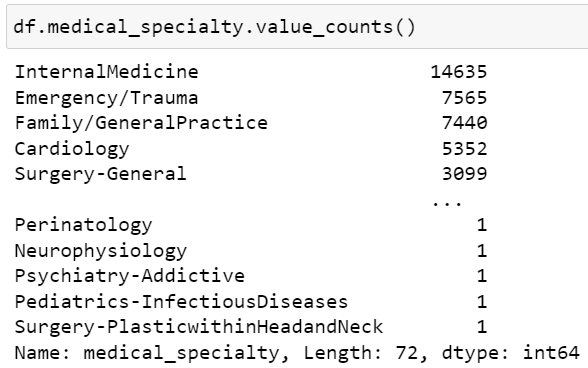

In [14]:
medical_specialty_null_per = (df.medical_specialty.isna().sum()/len(df))*100
print(f'Porcentaje de valores nulos: {medical_specialty_null_per}')

Porcentaje de valores nulos: 49.08220820313268


In [15]:
df.drop(columns='medical_specialty', inplace = True)

#### Variables diag_1, diag_2, diag_3
Estas tres variables presentan muy poca cantidad de registros nulos, por lo que se puede proceder con la eliminación de estos registros.

In [16]:
diag_1_null_per = (df.diag_1.isna().sum()/len(df))*100
print(f'Porcentaje de valores nulos: {diag_1_null_per}')

diag_2_null_per = (df.diag_2.isna().sum()/len(df))*100
print(f'Porcentaje de valores nulos: {diag_2_null_per}')

diag_3_null_per = (df.diag_3.isna().sum()/len(df))*100
print(f'Porcentaje de valores nulos: {diag_3_null_per}')

Porcentaje de valores nulos: 0.02063557573256294
Porcentaje de valores nulos: 0.3517874339170253
Porcentaje de valores nulos: 1.398305917497003


In [17]:
df.drop(df[df.diag_1.isna()].index, inplace = True)
df.reset_index(inplace = True, drop = True)

df.drop(df[df.diag_2.isna()].index, inplace = True)
df.reset_index(inplace = True, drop = True)

df.drop(df[df.diag_3.isna()].index, inplace = True)
df.reset_index(inplace = True, drop = True)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100244 entries, 0 to 100243
Data columns (total 46 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      100244 non-null  object
 1   gender                    100244 non-null  object
 2   age                       100244 non-null  object
 3   admission_type_id         100244 non-null  object
 4   discharge_disposition_id  100244 non-null  object
 5   admission_source_id       100244 non-null  object
 6   time_in_hospital          100244 non-null  int64 
 7   payer_code                100244 non-null  object
 8   num_lab_procedures        100244 non-null  int64 
 9   num_procedures            100244 non-null  int64 
 10  num_medications           100244 non-null  int64 
 11  number_outpatient         100244 non-null  int64 
 12  number_emergency          100244 non-null  int64 
 13  number_inpatient          100244 non-null  int64 
 14  diag

### Análisis de variabilidad por variable
Vamos a transformar las variables categóricas con ordinalEncoder para realizar el análisis de variabilidad para cada columna y a partir del VarianceThreshold vamos a eliminar aquellas que presenten una varibilidad inferior al 20%.

Esto lo realizo con el fin de asegurarme que las variables aporten variabilidad significativa al modelo y evitar utilizar variables que sean casi que constantes en sus registros.

In [19]:
# Tomo solo las variables categóricas de las variables independientes
obj_col = df.select_dtypes(include='object').columns.tolist()
obj_col.remove('readmitted')

In [20]:
# Entreno el OrdinalEncoder y transformo las variables.
ord_enc = OrdinalEncoder()
df[obj_col] = ord_enc.fit_transform(df[obj_col])

In [21]:
# Visualizo la transformación
df

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,num_lab_procedures,num_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,1.0,0.0,1.0,0.0,0.0,6.0,3,12.0,59,0,...,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,>30
1,0.0,0.0,2.0,0.0,0.0,6.0,2,12.0,11,5,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,NO
2,1.0,1.0,3.0,0.0,0.0,6.0,2,12.0,44,1,...,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NO
3,1.0,1.0,4.0,0.0,0.0,6.0,1,12.0,51,0,...,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NO
4,1.0,1.0,5.0,1.0,0.0,1.0,3,12.0,31,6,...,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,>30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100239,0.0,1.0,7.0,0.0,2.0,6.0,3,7.0,51,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,>30
100240,0.0,0.0,8.0,0.0,3.0,4.0,5,7.0,33,3,...,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,NO
100241,1.0,1.0,7.0,0.0,0.0,6.0,1,7.0,53,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NO
100242,1.0,0.0,8.0,1.0,2.0,6.0,10,7.0,45,2,...,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NO


In [22]:
# Utilizo la función de VarianceThreshold definiendo un threshold del 20%
var_thr = VarianceThreshold(threshold = 0.2)
var_thr.fit(df[obj_col])

VarianceThreshold(threshold=0.2)

In [23]:
# Determino las columnas con una variabilidad baja
constant_var = [col for col in df[obj_col].columns 
                if col not in df[obj_col].columns[var_thr.get_support()]]
constant_var

['max_glu_serum',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'diabetesMed']

In [24]:
# Antes de eliminar las variables, hago inverse_transform sobre los datos para tener las clases originales
df[obj_col] = pd.DataFrame(ord_enc.inverse_transform(df[obj_col]), columns=obj_col)

# Elimino las variables mencionadas
df.drop(columns = constant_var, inplace = True)

In [25]:
# Analizo los valores únicos para cada columna
df.nunique(axis=0)

race                          3
gender                        3
age                          10
admission_type_id             8
discharge_disposition_id     26
admission_source_id          17
time_in_hospital             14
payer_code                   18
num_lab_procedures          118
num_procedures                7
num_medications              75
number_outpatient            39
number_emergency             33
number_inpatient             20
diag_1                      715
diag_2                      743
diag_3                      789
number_diagnoses             14
A1Cresult                     4
insulin                       4
change                        2
readmitted                    3
dtype: int64

Al hacer el paso anterior para determinar los valores únicos en cada variable me causa curiosidad que gender tenga 3 clases y proceso a analizarla. Con esto descubro que esta columna tiene una etiqueta con solo 3 registros y procedo a eliminarlos

In [26]:
df.gender.value_counts()

Female             53922
Male               46319
Unknown/Invalid        3
Name: gender, dtype: int64

In [27]:
df.drop(index=df[df['gender']=='Unknown/Invalid'].index, inplace=True)
df.reset_index(inplace=True, drop=True)

### Transformación variables categóricas
Vamos a transformar las variables categóricas independientes a variables numéricas con OrdinalEncoder, pues si utilizamos getdummies o OneHotEncoding el número de variables sube a más de 2000, lo cual implicaría un proceso de análisis más detallado con técnicas de reducción de dimensionalidad como PCA.

Por otro lado, vamos a transformar la variable de salida con LabelEncoder y quedar así con una salida con 0, 1, 2.

In [28]:
# Variables categóricas
obj_col = df.select_dtypes(include='object').columns.tolist()
obj_col.remove('readmitted')

In [29]:
# Entreno el OrdinalEncoder y transformo las variables.
ord_enc = OrdinalEncoder()
df[obj_col] = ord_enc.fit_transform(df[obj_col])

In [30]:
# Variable de salida: entreno labelEncoder
label_enc = LabelEncoder()
df['readmitted'] = label_enc.fit_transform(df['readmitted'])

In [31]:
# Visualizamos el conjunto de datos con esta transformación
df

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,num_lab_procedures,num_procedures,...,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,A1Cresult,insulin,change,readmitted
0,1.0,0.0,1.0,0.0,0.0,6.0,3,12.0,59,0,...,0,0,143.0,78.0,121.0,9,2.0,3.0,0.0,1
1,0.0,0.0,2.0,0.0,0.0,6.0,2,12.0,11,5,...,0,1,454.0,77.0,766.0,6,2.0,1.0,1.0,2
2,1.0,1.0,3.0,0.0,0.0,6.0,2,12.0,44,1,...,0,0,554.0,96.0,248.0,7,2.0,3.0,0.0,2
3,1.0,1.0,4.0,0.0,0.0,6.0,1,12.0,51,0,...,0,0,54.0,23.0,86.0,5,2.0,2.0,0.0,2
4,1.0,1.0,5.0,1.0,0.0,1.0,3,12.0,31,6,...,0,0,263.0,245.0,86.0,9,2.0,2.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100236,0.0,1.0,7.0,0.0,2.0,6.0,3,7.0,51,0,...,0,0,102.0,147.0,295.0,9,1.0,0.0,0.0,1
100237,0.0,0.0,8.0,0.0,3.0,4.0,5,7.0,33,3,...,0,1,381.0,132.0,536.0,9,2.0,2.0,1.0,2
100238,1.0,1.0,7.0,0.0,0.0,6.0,1,7.0,53,0,...,0,0,236.0,388.0,159.0,13,2.0,0.0,0.0,2
100239,1.0,0.0,8.0,1.0,2.0,6.0,10,7.0,45,2,...,0,1,693.0,141.0,668.0,9,2.0,3.0,0.0,2


### Correlación de variables
Analizamos la correlación entre las variables de manera visual. Es posible observar que todas presentan una correlación inferior a 0.5, lo cual indica que no debemos eliminar variables por este motivo.

<AxesSubplot:>

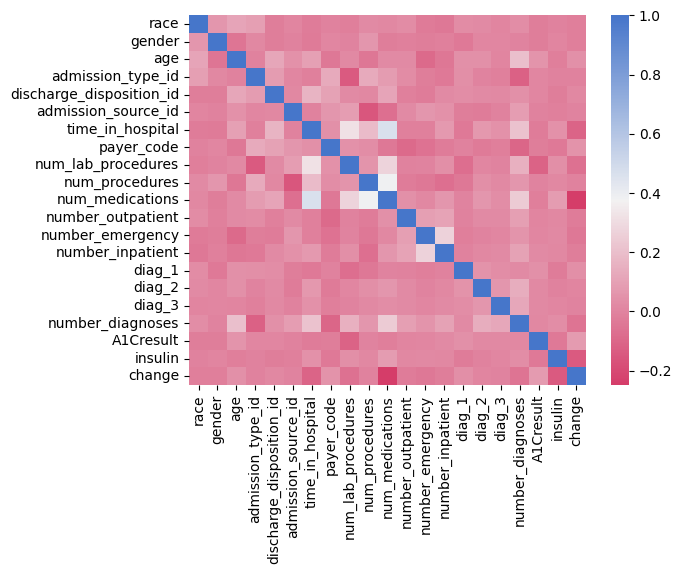

In [32]:
x_cols = df.columns.tolist()[:-1]
X = df[x_cols]
y = df['readmitted']

corr = X.corr()
sns.heatmap(corr,  xticklabels=corr.columns, yticklabels=corr.columns, cmap = sns.diverging_palette (0, 255, sep = 1, n = 256))

### Estandarización de variables
Llevaremos todas las columnas a valores entre 0 y 1 para prevenir que los modelos presenten perturbaciones por las diferencias de valores entre variables. Para eso utilizaremos la técnica de minmax.

In [33]:
scaler = MinMaxScaler()
df[x_cols] = scaler.fit_transform(df[x_cols])
df

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,num_lab_procedures,num_procedures,...,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,A1Cresult,insulin,change,readmitted
0,0.5,0.0,0.111111,0.000000,0.00,0.3750,0.153846,0.705882,0.442748,0.000000,...,0.0,0.000000,0.200280,0.105121,0.153553,0.461538,0.666667,1.000000,0.0,1
1,0.0,0.0,0.222222,0.000000,0.00,0.3750,0.076923,0.705882,0.076336,0.833333,...,0.0,0.047619,0.635854,0.103774,0.972081,0.230769,0.666667,0.333333,1.0,2
2,0.5,1.0,0.333333,0.000000,0.00,0.3750,0.076923,0.705882,0.328244,0.166667,...,0.0,0.000000,0.775910,0.129380,0.314721,0.307692,0.666667,1.000000,0.0,2
3,0.5,1.0,0.444444,0.000000,0.00,0.3750,0.000000,0.705882,0.381679,0.000000,...,0.0,0.000000,0.075630,0.030997,0.109137,0.153846,0.666667,0.666667,0.0,2
4,0.5,1.0,0.555556,0.142857,0.00,0.0625,0.153846,0.705882,0.229008,1.000000,...,0.0,0.000000,0.368347,0.330189,0.109137,0.461538,0.666667,0.666667,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100236,0.0,1.0,0.777778,0.000000,0.08,0.3750,0.153846,0.411765,0.381679,0.000000,...,0.0,0.000000,0.142857,0.198113,0.374365,0.461538,0.333333,0.000000,0.0,1
100237,0.0,0.0,0.888889,0.000000,0.12,0.2500,0.307692,0.411765,0.244275,0.500000,...,0.0,0.047619,0.533613,0.177898,0.680203,0.461538,0.666667,0.666667,1.0,2
100238,0.5,1.0,0.777778,0.000000,0.00,0.3750,0.000000,0.411765,0.396947,0.000000,...,0.0,0.000000,0.330532,0.522911,0.201777,0.769231,0.666667,0.000000,0.0,2
100239,0.5,0.0,0.888889,0.142857,0.08,0.3750,0.692308,0.411765,0.335878,0.333333,...,0.0,0.047619,0.970588,0.190027,0.847716,0.461538,0.666667,1.000000,0.0,2


In [34]:
# Verificamos que el escalamiento haya sido satisfactorio al conocer el valor máximo y mínimo de cada variable
df.describe()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,num_lab_procedures,num_procedures,...,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,A1Cresult,insulin,change,readmitted
count,100241.000000,100241.000000,100241.000000,100241.000000,100241.000000,100241.000000,100241.000000,100241.000000,100241.000000,100241.000000,...,100241.000000,100241.000000,100241.000000,100241.000000,100241.000000,100241.000000,100241.000000,100241.000000,100241.000000,100241.000000
mean,0.437151,0.462076,0.680850,0.146109,0.107699,0.284480,0.263101,0.534791,0.321939,0.225039,...,0.002619,0.030452,0.472975,0.372125,0.356431,0.345927,0.631698,0.468188,0.537614,1.424657
std,0.242496,0.498562,0.173167,0.206418,0.205847,0.219698,0.230097,0.222333,0.150316,0.285150,...,0.012284,0.060133,0.223898,0.204096,0.223175,0.141501,0.172538,0.279528,0.498586,0.684680
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.000000,0.555556,0.000000,0.000000,0.000000,0.076923,0.411765,0.236641,0.000000,...,0.000000,0.000000,0.362745,0.190027,0.176396,0.230769,0.666667,0.333333,0.000000,1.000000
50%,0.500000,0.000000,0.666667,0.000000,0.000000,0.375000,0.230769,0.470588,0.328244,0.166667,...,0.000000,0.000000,0.417367,0.349057,0.324873,0.384615,0.666667,0.333333,1.000000,2.000000
75%,0.500000,1.000000,0.777778,0.285714,0.120000,0.375000,0.384615,0.705882,0.427481,0.333333,...,0.000000,0.047619,0.609244,0.505391,0.470812,0.461538,0.666667,0.666667,1.000000,2.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


In [35]:
# Finalmente, revisamos si hay presencia de registros duplicados para eliminarlos
df.drop_duplicates(inplace=True, ignore_index=True)

In [36]:
#sns.pairplot(df, hue='readmitted')

## Entrenamiento de modelos
Una vez finalizada la etapa de Análisis Exploratorio y Preprocesamiento de datos, podemos concluir que predeciremos la variable dependiente con un total de 21 variables independientes. Además, los registros a utilizar representan una muestra significativa para el estudio gracias a la variabilidad que estos presentan y a la limpieza a la cual fueron sometidos.

Las variables seleccionadas parecen tener sentido para el estudio, pues involucran el género, edad y raza del paciente, al igual que el tiempo en el hospital, la forma de ingreso, número de días en la última visita, diagnósticos, entre otros.

Ahora, en esta etapa de entrenamiento procederemos de la siguiente manera:
1. Análisis de la variable respuesta
2. Entrenamiento de modelos
3. Validación de resultados

In [37]:
print(f'Trabajaremos con un total de {df.shape[0]} filas y {df.shape[1]} columnas de ahora en adelante')

Trabajaremos con un total de 100241 filas y 22 columnas de ahora en adelante


### Análisis de la variable respuesta
A partir de la variable respuesta podremos identificar la forma más adecuada para particionar los datos según que tan balanceados se encuentran nuestros datos.

In [38]:
df.readmitted.value_counts()

2    53818
1    35173
0    11250
Name: readmitted, dtype: int64

Text(0.5, 0, 'Días hasta readmisión')

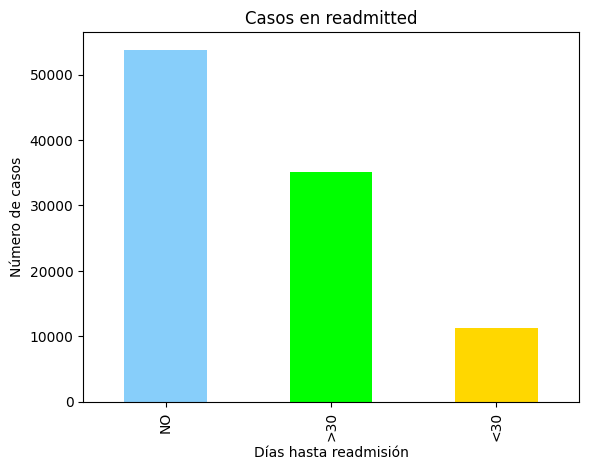

In [39]:
df.readmitted.value_counts().plot(kind='bar', color=['lightskyblue', 'lime', 'gold'])
plt.title('Casos en readmitted')
plt.xticks([0, 1, 2], ['NO', '>30', '<30'])
plt.ylabel('Número de casos')
plt.xlabel('Días hasta readmisión')

De lo anterior se puede observar un evidente desbalance en las etiquetas, por lo que se recomienda trabajar con un undersampling de la clase mayoritaria y de esta manera igualar la cantidad de registros de cada clase. En un futuro se podría emplear una técnica de oversampling para aumentar el número de registros.

In [40]:
X = df[x_cols]
y = df.readmitted

n_class = round(df.readmitted.value_counts().min()*0.8)

undersample = RandomUnderSampler(sampling_strategy={2:n_class,1: n_class, 0:n_class})
X_under, y_under = undersample.fit_resample(X, y)

Text(0.5, 0, 'Días hasta readmisión')

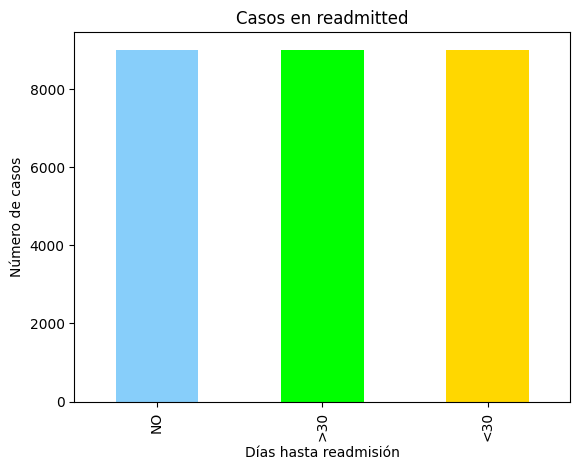

In [41]:
y_under.value_counts().plot(kind='bar', color=['lightskyblue', 'lime', 'gold'])
plt.title('Casos en readmitted')
plt.xticks([0, 1, 2], ['NO', '>30', '<30'])
plt.ylabel('Número de casos')
plt.xlabel('Días hasta readmisión')

Dividimos el conjunto de datos en train, test y val. Los de train y test se emplearán para entrenar y validar el modelo con validación cruzada y el de validación para validar los resultados del modelo con datos que el modelo no haya visto anteriormente.

In [42]:
df_train_test = pd.concat([X_under, y_under], axis = 1)
df_val = pd.concat([df, df_train_test]).drop_duplicates(keep=False)
df_val.reset_index(inplace=True, drop=True)

print(f'Tendremos {df_train_test.shape[0]} datos para train y test y {df_val.shape[0]} para validación')

Tendremos 27000 datos para train y test y 73241 para validación


### Entrenamiento
Teniendo en cuenta la naturaleza de la variable de salida, entrenaremos modelos de aprendizaje supervisado que nos permitan realizar predicción multiclase. Entrenaremos tres modelos diferentes para los cuales realizaremos validación cruzada para asegurarnos del desempeño de cada uno. 


En esta etapa se entrenarán los modelos con los valores predeterminados de python debido a la limitante de tiempo que tenemos, de lo contrario procederíamos con búsqueda de hiperparámetros. También evaluaremos el desempeño del modelo con la métrica por defecto de cada uno, es decir mean accuracy. Sin embargo, para un mejor estudio se recomienda analizar múltiples métricas y de esta forma tomar mejores decisiones.

In [43]:
X_train = df_train_test[x_cols]
y_train = df_train_test.readmitted

In [44]:
modelSVM = OneVsOneClassifier(SVC(random_state=42)).fit(X_train,y_train)

# Métricas del modelo con validación cruzada 
cv_scores = cross_val_score(modelSVM, X_train, y_train, cv=5)

print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

[0.43648148 0.44537037 0.42481481 0.43425926 0.42388889]
cv_scores mean:0.432962962962963


In [45]:
modelRF = OneVsOneClassifier(RandomForestClassifier(n_estimators = 1000, random_state =42)).fit(X_train,y_train)

# Métricas del modelo con validación cruzada 
cv_scores = cross_val_score(modelRF, X_train, y_train, cv=5)

print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

[0.46111111 0.46888889 0.4587037  0.4587037  0.45351852]
cv_scores mean:0.4601851851851852


In [46]:
modelKNN = OneVsOneClassifier(KNeighborsClassifier()).fit(X_train,y_train)

# Métricas del modelo con validación cruzada 
cv_scores = cross_val_score(modelKNN, X_train, y_train, cv=5)

print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

[0.37203704 0.38518519 0.38425926 0.36814815 0.37722222]
cv_scores mean:0.37737037037037036


#### Matrices de confusión en train
Adicional a la métrica presentada en la etapa anterior, presentamos de manera visual el comportamiento de cada modelo con su predicción y un reporte de clasificación con diferentes métricas.

In [49]:
y_pred_svm = modelSVM.predict(X_train)
y_pred_knn = modelKNN.predict(X_train)
y_pred_rf  = modelRF.predict(X_train)

[[5641 1369 1990]
 [2948 3546 2506]
 [3242 2023 3735]]
-----------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.51      0.39      0.44      9000
           1       0.45      0.41      0.43      9000
           2       0.48      0.63      0.54      9000

    accuracy                           0.48     27000
   macro avg       0.48      0.48      0.47     27000
weighted avg       0.48      0.48      0.47     27000



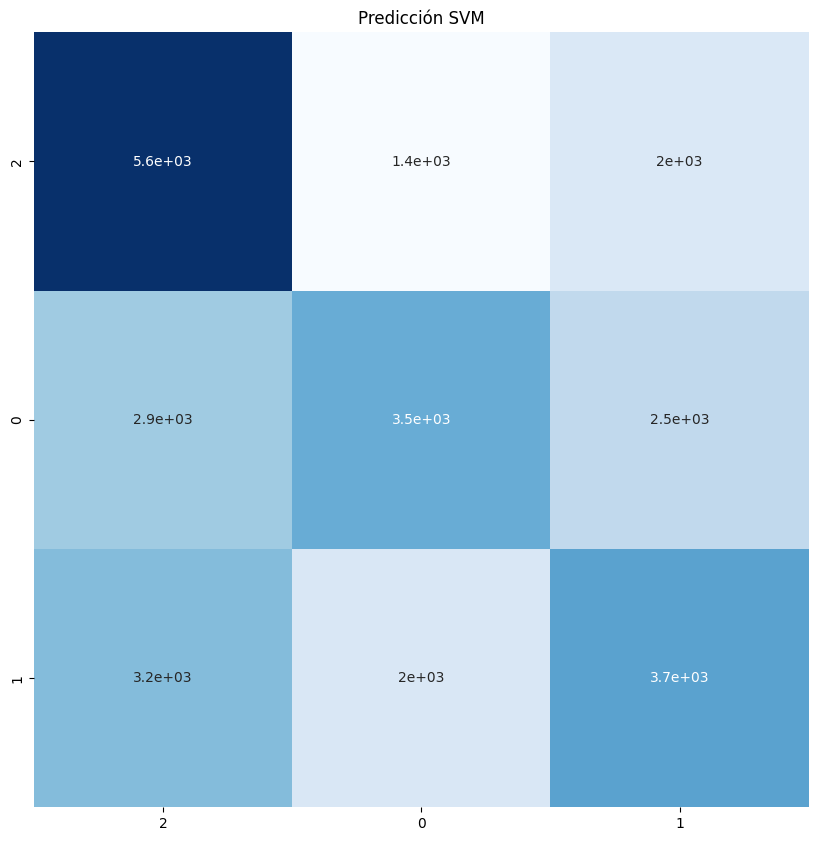

In [51]:
columnas = pd.DataFrame(y_pred_svm)[0].unique().tolist()

confm = confusion_matrix(y_train, y_pred_svm, labels = columnas)
print(confm)

df_cm = pd.DataFrame(confm, index = columnas, columns=columnas)

f,(ax1) = plt.subplots(1,1, figsize=(5,5))
ax1 = grafica = sns.heatmap(df_cm, square=True, cbar=False, cmap = "Blues", annot = True, ax = ax1)
ax1.set_title('Predicción SVM')

print('-----------------------------------------------------------------------------------')

print(classification_report(y_train,y_pred_svm))

[[5110 2122 1768]
 [1867 5230 1903]
 [1804 2062 5134]]
-----------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.58      0.57      0.57      9000
           1       0.56      0.58      0.57      9000
           2       0.58      0.57      0.58      9000

    accuracy                           0.57     27000
   macro avg       0.57      0.57      0.57     27000
weighted avg       0.57      0.57      0.57     27000



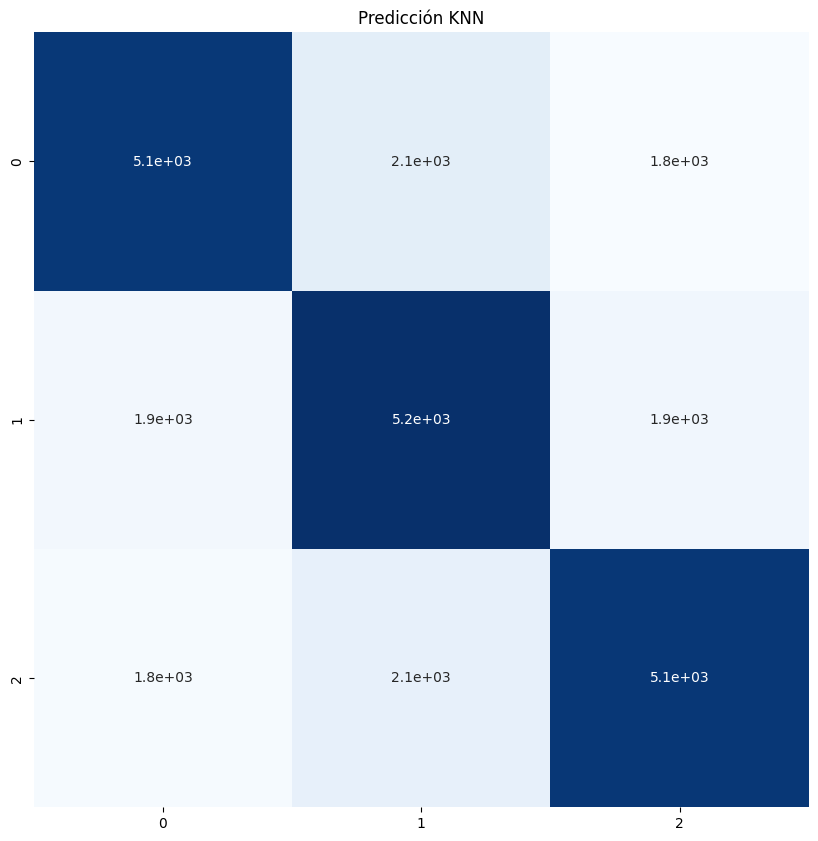

In [52]:
columnas = pd.DataFrame(y_pred_knn)[0].unique().tolist()

confm = confusion_matrix(y_train, y_pred_knn, labels = columnas)
print(confm)

df_cm = pd.DataFrame(confm, index = columnas, columns=columnas)

f,(ax1) = plt.subplots(1,1, figsize=(5,5))
ax1 = grafica = sns.heatmap(df_cm, square=True, cbar=False, cmap = "Blues", annot = True, ax = ax1)
ax1.set_title('Predicción KNN')

print('-----------------------------------------------------------------------------------')

print(classification_report(y_train,y_pred_knn))

[[9000    0    0]
 [   0 9000    0]
 [   0    0 9000]]
-----------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       1.00      1.00      1.00      9000
           2       1.00      1.00      1.00      9000

    accuracy                           1.00     27000
   macro avg       1.00      1.00      1.00     27000
weighted avg       1.00      1.00      1.00     27000



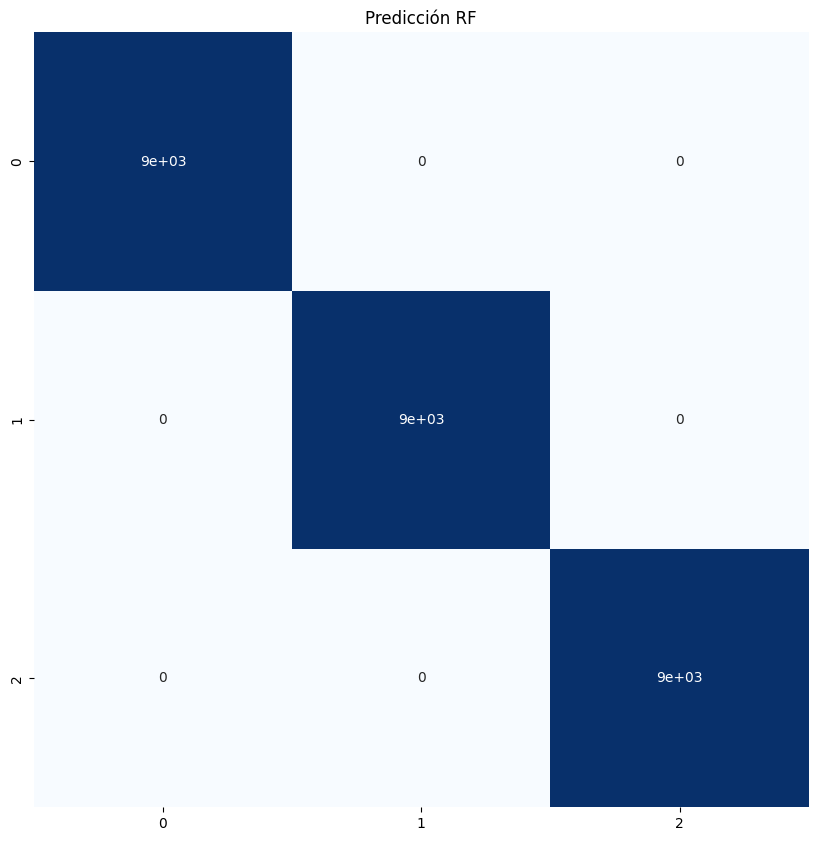

In [53]:
columnas = pd.DataFrame(y_pred_rf)[0].unique().tolist()

confm = confusion_matrix(y_train, y_pred_rf, labels = columnas)
print(confm)

df_cm = pd.DataFrame(confm, index = columnas, columns=columnas)

f,(ax1) = plt.subplots(1,1, figsize=(5,5))
ax1 = grafica = sns.heatmap(df_cm, square=True, cbar=False, cmap = "Blues", annot = True, ax = ax1)
ax1.set_title('Predicción RF')

print('-----------------------------------------------------------------------------------')

print(classification_report(y_train,y_pred_rf))

Según los resultados obtenidos en esta etapa de entrenamiento podemos resaltar lo siguiente:
- El modelo de Random Forest, al tratarse de un ensamble de árboles, resulta ser un modelo bastante eficiente. Aún así, se debe verificar en la etapa de validación que este no se esté sobreentrenando al aprenderse los datos de entrenamiento. Este resultado con métricas tan perfectas podría ajustarse para evitar un posible overfitting apartir de una búsqueda de hiperparámetros adecuada.
- El método de SVM es el que presenta métricas más bajas, siendo incluso inferiores al 50%, demostrando que el modelo no tiene capacidad de predicción.
- El método KNN también presenta confusiones en su predicción. Sin embargo, es un método muy adaptable desde sus hiperparámetros, pero en esta ocasión se consideran los valores por defecto de python.

### Validación de resultados
De manera similar a como procedimos anteriormente, realizaremos una validación con los datos que el modelo no ha visto anteriormente y así verificar su desempeño.

In [54]:
X_val = df_val[x_cols]
y_val = df_val.readmitted

In [55]:
y_pred_svm = modelSVM.predict(X_val)
y_pred_knn = modelKNN.predict(X_val)
y_pred_rf  = modelRF.predict(X_val)

[[25988  7782 11048]
 [  785   822   643]
 [10124  6484  9565]]
-----------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.05      0.37      0.09      2250
           1       0.45      0.37      0.40     26173
           2       0.70      0.58      0.64     44818

    accuracy                           0.50     73241
   macro avg       0.40      0.44      0.38     73241
weighted avg       0.59      0.50      0.54     73241



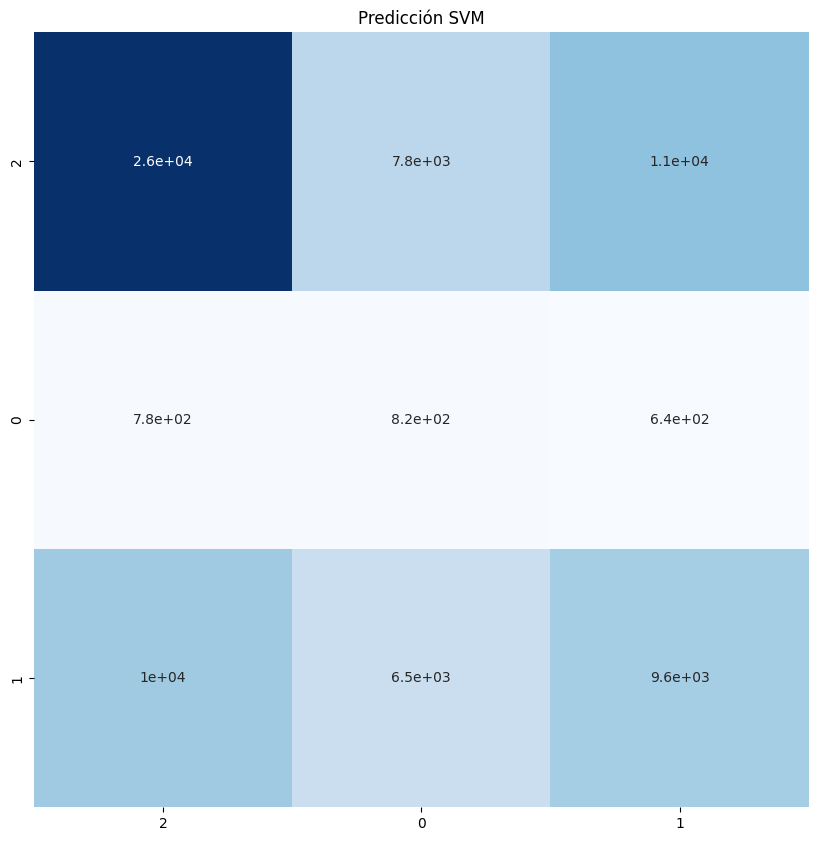

In [56]:
columnas = pd.DataFrame(y_pred_svm)[0].unique().tolist()

confm = confusion_matrix(y_val, y_pred_svm, labels = columnas)
print(confm)

df_cm = pd.DataFrame(confm, index = columnas, columns=columnas)

f,(ax1) = plt.subplots(1,1, figsize=(5,5))
ax1 = grafica = sns.heatmap(df_cm, square=True, cbar=False, cmap = "Blues", annot = True, ax = ax1)
ax1.set_title('Predicción SVM')

print('-----------------------------------------------------------------------------------')

print(classification_report(y_val,y_pred_svm))

[[16903 14881 13034]
 [ 7832  9876  8465]
 [  640   768   842]]
-----------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.04      0.37      0.07      2250
           1       0.39      0.38      0.38     26173
           2       0.67      0.38      0.48     44818

    accuracy                           0.38     73241
   macro avg       0.36      0.38      0.31     73241
weighted avg       0.55      0.38      0.43     73241



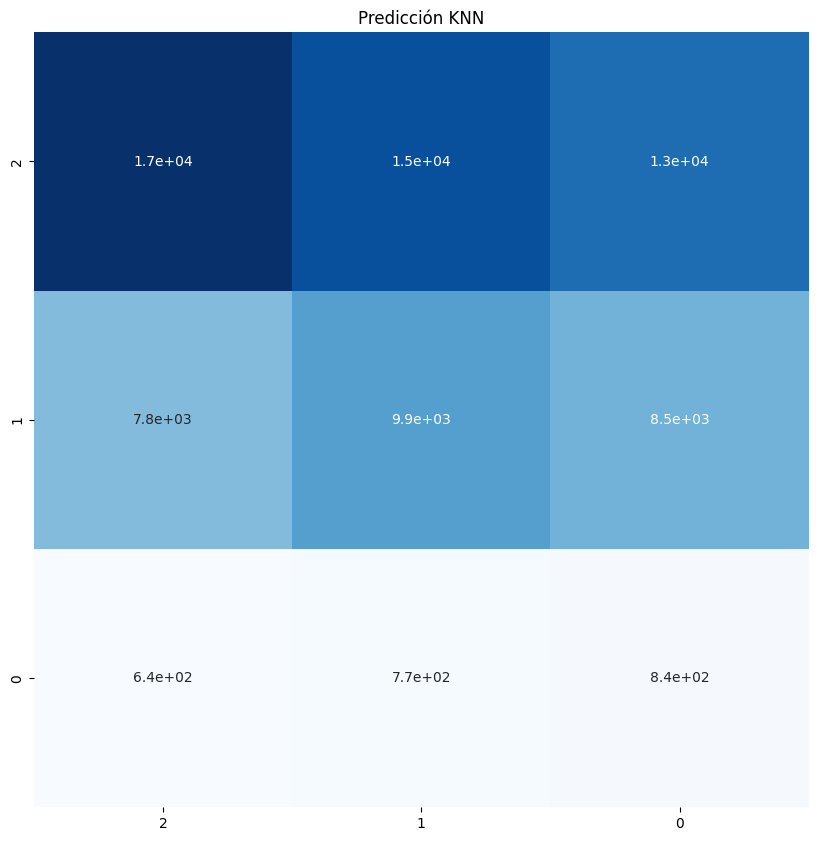

In [57]:
columnas = pd.DataFrame(y_pred_knn)[0].unique().tolist()

confm = confusion_matrix(y_val, y_pred_knn, labels = columnas)
print(confm)

df_cm = pd.DataFrame(confm, index = columnas, columns=columnas)

f,(ax1) = plt.subplots(1,1, figsize=(5,5))
ax1 = grafica = sns.heatmap(df_cm, square=True, cbar=False, cmap = "Blues", annot = True, ax = ax1)
ax1.set_title('Predicción KNN')

print('-----------------------------------------------------------------------------------')

print(classification_report(y_val,y_pred_knn))

[[ 9689  8689  7795]
 [10340 25697  8781]
 [  609   670   971]]
-----------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.06      0.43      0.10      2250
           1       0.47      0.37      0.41     26173
           2       0.73      0.57      0.64     44818

    accuracy                           0.50     73241
   macro avg       0.42      0.46      0.39     73241
weighted avg       0.62      0.50      0.54     73241



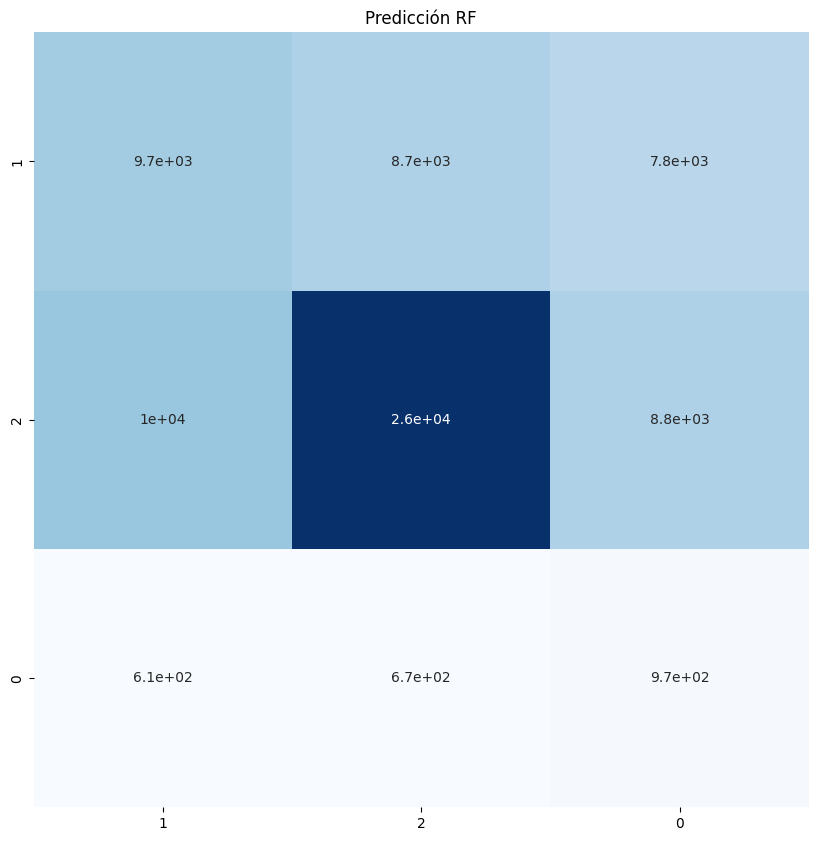

In [58]:
columnas = pd.DataFrame(y_pred_rf)[0].unique().tolist()

confm = confusion_matrix(y_val, y_pred_rf, labels = columnas)
print(confm)

df_cm = pd.DataFrame(confm, index = columnas, columns=columnas)

f,(ax1) = plt.subplots(1,1, figsize=(5,5))
ax1 = grafica = sns.heatmap(df_cm, square=True, cbar=False, cmap = "Blues", annot = True, ax = ax1)
ax1.set_title('Predicción RF')

print('-----------------------------------------------------------------------------------')

print(classification_report(y_val,y_pred_rf))

De estos resultados debemos destacar que ninguno de los modelos presenta predicciones adecuadas de las clases, pues se evidencian múltiples errores en las matrices de confusión. Sin embargo, se puede descartar un sobreentrenamiento ya que las métricas obtenidas en esta etapa son inferiores. Aún así se debe mencionar que esta muestra de validación se encuentra desbalanceada, por lo que resulta mejor analizar las métricas individuales para cada clase y no la del modelo general.

# Propuesta de futuro trabajo:
Finalmente, teniendo en cuenta la limitante de tiempo, la solución propuesta abarca una forma sencilla de como abordar la problemática. Sin embargo, los resultados pueden mejorarse con la implementación de técnicas más avanzadas. Por ejemplo:
- Feature Selection: agrupamiento de clases de las variables categóricas, apoyo de conocimiento experto en tema médico, visualizaciones de datos, reducción de dimensión, encoding...
- Balanceo de clases: técnicas de oversampling de la clase minoritaria, generación de nuevos datos, métodos de ensamble, más datos históricos en caso de que el cliente posea esta información
- Entrenamiento: selección de otro tipo de modelos, búsqueda de hiperparámetros, combinación de algoritmos con baggind y boosting